# Notebook to test SetFit performance

Check CUDA

In [3]:
import torch
if torch.cuda.is_available():    
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

Load dataset and transform data

In [4]:
import pandas as pd
import numpy as np

dataFrame = pd.read_pickle(r'../data/7587_corrige.pkl')

In [5]:
subset = dataFrame[['jobTitle', 'description', 'label']].copy()

subset.reset_index(drop=True, inplace=True)
subset.replace('', np.nan, inplace=True)
subset.dropna(inplace=True)

subset['text'] = subset['jobTitle'] + ' ' + subset['description']
subset['label'] = np.where((subset["label"] < 3) | (subset["label"].isna()), 0, 1)
subset = subset[['text','label']]
subset

,text,label
2,Stagiaire ingénieur en intelligence artificiel...,1
3,Stagiaire en développement logiciel Développem...,0
4,Stagiaire en développement Web Création et évo...,0
5,Stagiaire en développement Web Portage d’une a...,0
6,Développeur Data / IA Développement d'applicat...,1
...,...,...
11281,Opérateur production Montage de transmission a...,0
11282,Opérateur production Montage de transmission a...,0
11283,Technicien réparation informatique Reparation ...,0
11284,Technicien réparation Reparation & maintenance...,0


Split the dataset in two: training and test set

In [6]:
from datasets import Dataset

def split_train_test(dataset, ratio):
    test_set = dataset.sample(frac = ratio, random_state=42)
    train_set = dataset.drop(test_set.index)
    return train_set, test_set

train_set, test_set = split_train_test(subset, 0.2)

# Functions to test different hyper parameters

In [7]:
import json
from datetime import datetime
import os


def save_to_json(object, folder_path):
	# Create folder if it doesn't exist
	if not os.path.exists(folder_path):
		os.makedirs(folder_path)
	# Generate file name
	date = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
	file_name = folder_path+'/'+str(date)+".txt"

	# Create file and save data
	with open(file_name, 'w') as file:
		json.dump(object, file)

In [8]:
from sentence_transformers.losses import CosineSimilarityLoss, BatchAllTripletLoss
from setfit import Trainer, TrainingArguments, sample_dataset, SetFitModel
import gc
import time

num_classes = 2

def get_transformer_model(model_name):
    model = SetFitModel.from_pretrained(model_name)
    gc.collect()
    torch.cuda.empty_cache()
    
    return model.to('cuda')

def init_trainer(model, loss, train_dataset, test_dataset):
    trainer_arguments = TrainingArguments(
        loss=loss,
        batch_size=(8,2),
        num_epochs=(1,10) # Number of epochs to use for contrastive learning (for the transformer and for the classification head)
    )

    trainer = Trainer(
        model=model,
        args=trainer_arguments,
        metric='f1',
        train_dataset=train_dataset,
        eval_dataset=test_dataset
    )
    return trainer

def setfit_f1_score(train_set, test_set, model_name, loss):   
    if len(train_set) <= 1 or len(test_set) <= 1:
        raise Exception
    
    model = get_transformer_model(model_name)
    trainer = init_trainer(model, loss, train_set, test_set)
    
    start_time = time.time()
    trainer.train()
    run_time = time.time() - start_time
    
    metrics = trainer.evaluate()
    
    del model
    del trainer
    torch.cuda.empty_cache()
    
    return metrics['f1'], run_time

In [9]:
from langdetect import detect

def filter_lang(df, lang):
    indices = []
    for i in range(len(df)):
        try:
            l = detect(df.iloc[i]["text"])
            if l == lang:
                indices.append(i)
        except:""
    
    return df.iloc[indices]

def filter_dataset(data, min_text_length=None, max_text_length=None, lang=None):
    if min_text_length is None:
        if max_text_length is None:
            filtered_data = data
        else:
            filtered_data = data[data['text'].str.split().apply(len) <= max_text_length]
    else:
        if max_text_length is None:
            filtered_data = data[data['text'].str.split().apply(len) >= min_text_length]
        else:
            filtered_data = data[data['text'].str.split().apply(len).between(min_text_length, max_text_length)]
            
    if not (lang is None):
        filtered_data = filter_lang(filtered_data, lang)
           
    return filtered_data

### N-Shots

In [10]:
def n_shot_tests(params, train_set, test_set):
	n_values = params["n_shot"]
	n_iter = params["n_iter"]
	n_max_iter_per_shot = params["n_max_iter_per_shot"]
	model = params["model"]
	loss = params["loss"]
    
	n_values_max = np.max(n_values)

	results = {}
	run_times = {}
	for n_shot in n_values:
		results[n_shot] = []
		run_times[n_shot] = []
  
	# Repeat the tests multiple times because F1-score variations might be due to the examples chosen and not the input length of those examples
	for i in range(n_iter):
		print("Step:", i, "/", n_iter)
		# Use the same subset of the dataset for all of the tests in the following loop
		new_train_set = train_set.sample(frac = 1, random_state=i*47).groupbN('label').head(n_values_max)
		new_train_set = Dataset.from_pandas(new_train_set, split="train")
		new_test_set = Dataset.from_pandas(test_set, split="test")

		for n_shot in n_values:
			if n_shot in results:
				try:
					n_iter_shot = n_max_iter_per_shot if n_shot < n_values_max else 1
					for i_shot in range(n_iter_shot):
						train_set_n_shot = sample_dataset(new_train_set, label_column="label", num_samples=n_shot, seed=47*n_shot + 3*i_shot)
						f1_score, run_time = setfit_f1_score(train_set_n_shot, new_test_set, model, loss)
						results[n_shot].append(f1_score)
						run_times[n_shot].append(run_time)
				except:""
	return results, run_times

### Input length

In [11]:
def input_length_tests(params, train_set, test_set):
	n_shot = params["n_shot"]
	len_values = params["input_length_range"]
	n_iter = params["n_iter"]
	model = params["model"]
	loss = params["loss"]
    
	results = {}
	run_times = {}
	new_test_set = Dataset.from_pandas(test_set, split="test")

	for i in range(len(len_values)):
		key = f"[{len_values[i][0]},{len_values[i][1]}]"
		results[key] = []
		run_times[key] = []
		
	results['all'] = []
	run_times['all'] = []

	# Repeat the tests multiple times because F1-score variations might be due to the examples chosen and not the input length of those examples
	for iter in range(n_iter):
		print("Step:", iter, "/", n_iter)
		for i in range(len(len_values)):
			key = f"[{len_values[i][0]},{len_values[i][1]}]"
			if key in results:
				try:
					new_train_set = filter_dataset(train_set, len_values[i][0], len_values[i][1])
					new_train_set = Dataset.from_pandas(new_train_set, split="train")
					new_train_set = sample_dataset(new_train_set, label_column="label", num_samples=n_shot, seed=47*iter)
					f1_score, run_time = setfit_f1_score(new_train_set, new_test_set, model, loss)
					results[key].append(f1_score)
					run_times[key].append(run_time)
				except Exception as err:
					print(key, "failed", str(err))
	
		# Additional test (no length constraint)
		if 'all' in results:
			try:
				new_train_set = Dataset.from_pandas(train_set, split="train")
				new_train_set = sample_dataset(new_train_set, label_column="label", num_samples=n_shot, seed=47*iter)
				f1_score, run_time = setfit_f1_score(new_train_set, new_test_set, model, loss)
				results['all'].append(f1_score)
				run_times['all'].append(run_time)
			except:""
	return results, run_times

### Distance

In [11]:
def distance_tests(params, train_set, test_set):
	n_shot = params["n_shot"]
	n_iter = params["n_iter"]
	model = params["model"]
	losses = params["loss"]

	results = {}
	run_times = {}
	for key in losses.keys():
		results[key] = []
		run_times[key] = []

	new_test_set = Dataset.from_pandas(test_set, split="test")

	for i in range(n_iter):
		print("Step:", i, "/", n_iter)
		new_train_set = Dataset.from_pandas(train_set, split="train")
		new_train_set = sample_dataset(new_train_set, label_column="label", num_samples=n_shot, seed=47*i)
		
		for key in losses.keys():
			f1_score, run_time = setfit_f1_score(new_train_set, new_test_set, model, losses[key])
			results[key].append(f1_score)
			run_times[key].append(run_time)
	return results, run_times

### Language

In [12]:

def language_tests(params, train_set, test_set):
	n_shot = params["n_shot"]
	n_iter = params["n_iter"]
	model = params["model"]
	loss = params["loss"]
	languages = params["lang"]
 
	results = {}
	run_times = {}

	for key in languages:
		results[key] = []
		run_times[key] = []
	results['all'] = []
	run_times['all'] = []
 
	for i in range(n_iter):
		print("Step:", i, "/", n_iter)
		temp_train_set_panda = {}
		temp_test_set_panda = {}

		for key in languages:
			temp_train_set_panda[key] = filter_dataset(train_set, lang=key)
			temp_train_set = Dataset.from_pandas(temp_train_set_panda[key], split="train")
			temp_train_set = sample_dataset(temp_train_set, label_column="label", num_samples=n_shot, seed=47*i)
   
			temp_test_set_panda[key] = filter_dataset(test_set, lang=key)
			temp_test_set = Dataset.from_pandas(temp_test_set_panda[key], split="test")
			try:
				f1_score, run_time = setfit_f1_score(temp_train_set, temp_test_set, model, loss)
				results[key].append(f1_score)
				run_times[key].append(run_time)
			except Exception as err:
				del temp_train_set_panda[key]
				del temp_test_set_panda[key]
		
		all_temp_train_set = list(temp_train_set_panda.values())
		all_temp_test_set = list(temp_train_set_panda.values())
  
		if len(all_temp_train_set) == 0 or len(all_temp_test_set) == 0:
			continue

		all_train_set = pd.concat(all_temp_train_set)
		all_train_set = Dataset.from_pandas(all_train_set, split="test")
		all_train_set = sample_dataset(all_train_set, label_column="label", num_samples=n_shot, seed=47*i)
		all_test_set = pd.concat(all_temp_test_set)
		all_test_set = Dataset.from_pandas(all_test_set, split="test")
		try:
			f1_score, run_time = setfit_f1_score(all_train_set, all_test_set, model, loss)
			results['all'].append(f1_score)
			run_times['all'].append(run_time)
		except: ""
	return results, run_times

### Sentence transformers

Test SetFit with different ST models

In [13]:
def model_tests(params, train_set, test_set):
	n_shot = params["n_shot"]
	n_iter = params["n_iter"]
	loss = params["loss"]
	models = params["model"]
 
	results = {}
	run_times = {}
	new_test_set = Dataset.from_pandas(test_set, split="test")

	for key in models.keys():
		results[key] = []
		run_times[key] = []

	for i in range(n_iter):
		print("Step:", i, "/", n_iter)

		# Use the same subset of the dataset for all of the tests in the following loop
		new_train_set = Dataset.from_pandas(train_set, split="train")
		new_train_set = sample_dataset(new_train_set, label_column="label", num_samples=n_shot, seed=47*i)

		for key, full_model_name in models.items():
			try:
				f1_score, run_time = setfit_f1_score(new_train_set, new_test_set, full_model_name, loss)
				results[key].append(f1_score)
				run_times[key].append(run_time)
			except: ""
	return results, run_times

## Run tests

In [13]:
def loss_to_str(loss):
    if loss == CosineSimilarityLoss:
        return "Cosine"
    elif loss == BatchAllTripletLoss:
        return "Triplet"
    else:
        return ""

### N-shots

By default SetFit uses the oversampling strategy. For instance if we have 8 positive and 8 negative examples then we have:

|   | Y | Y | Y | Y | Y | Y | Y | Y | N | N | N | N | N | N | N | N |
|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|
| Y | + | + | + | + | + | + | + | + | - | - | - | - | - | - | - | - |
| Y |   | + | + | + | + | + | + | + | - | - | - | - | - | - | - | - |
| Y |   |   | + | + | + | + | + | + | - | - | - | - | - | - | - | - |
| Y |   |   |   | + | + | + | + | + | - | - | - | - | - | - | - | - |
| Y |   |   |   |   | + | + | + | + | - | - | - | - | - | - | - | - |
| Y |   |   |   |   |   | + | + | + | - | - | - | - | - | - | - | - |
| Y |   |   |   |   |   |   | + | + | - | - | - | - | - | - | - | - |
| Y |   |   |   |   |   |   |   | + | - | - | - | - | - | - | - | - |
| N |   |   |   |   |   |   |   |   | + | + | + | + | + | + | + | + |
| N |   |   |   |   |   |   |   |   |   | + | + | + | + | + | + | + |
| N |   |   |   |   |   |   |   |   |   |   | + | + | + | + | + | + |
| N |   |   |   |   |   |   |   |   |   |   |   | + | + | + | + | + |
| N |   |   |   |   |   |   |   |   |   |   |   |   | + | + | + | + |
| N |   |   |   |   |   |   |   |   |   |   |   |   |   | + | + | + |
| N |   |   |   |   |   |   |   |   |   |   |   |   |   |   | + | + |
| N |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   | + |

- P = 2 * (8 + 7 + 6 + 5 + 4 + 3 + 2 + 1) 	= 72
- N = 8 * 8 = 64 -> + 8 duplications 		= 72
- Total = 72 + 72 = 144

In [14]:
params = {
	"n_shot": [1,5,10,30],
	"n_iter": 5,
 	"n_max_iter_per_shot": 3,
	"model": "sentence-transformers/paraphrase-mpnet-base-v2",
	"loss": CosineSimilarityLoss
}

results, run_times = n_shot_tests(params, train_set, test_set)

params["loss"] = loss_to_str(params["loss"])
save_to_json({"results":results, "run_times":run_times, "const_params": params},  r'../results/setfit/n_shot')

Step: 0 / 5


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/2 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 4
  Batch size = 4
  Num epochs = 1
  Total optimization steps = 1


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

***** Running evaluation *****


{'embedding_loss': 0.033, 'learning_rate': 0.0, 'epoch': 1.0}
{'train_runtime': 0.7443, 'train_samples_per_second': 10.749, 'train_steps_per_second': 1.344, 'epoch': 1.0}


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/2 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 4
  Batch size = 4
  Num epochs = 1
  Total optimization steps = 1


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

***** Running evaluation *****


{'embedding_loss': 0.0201, 'learning_rate': 0.0, 'epoch': 1.0}
{'train_runtime': 0.288, 'train_samples_per_second': 27.778, 'train_steps_per_second': 3.472, 'epoch': 1.0}


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/2 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 4
  Batch size = 4
  Num epochs = 1
  Total optimization steps = 1


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

***** Running evaluation *****


{'embedding_loss': 0.0592, 'learning_rate': 0.0, 'epoch': 1.0}
{'train_runtime': 0.47, 'train_samples_per_second': 17.021, 'train_steps_per_second': 2.128, 'epoch': 1.0}


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/10 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 60
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 8


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

{'embedding_loss': 0.1269, 'learning_rate': 2e-05, 'epoch': 0.12}
{'train_runtime': 2.661, 'train_samples_per_second': 24.051, 'train_steps_per_second': 3.006, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/10 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 60
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 8


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

{'embedding_loss': 0.2479, 'learning_rate': 2e-05, 'epoch': 0.12}
{'train_runtime': 3.127, 'train_samples_per_second': 20.467, 'train_steps_per_second': 2.558, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/10 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 60
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 8


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

{'embedding_loss': 0.258, 'learning_rate': 2e-05, 'epoch': 0.12}
{'train_runtime': 2.815, 'train_samples_per_second': 22.735, 'train_steps_per_second': 2.842, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/20 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 220
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 28


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

{'embedding_loss': 0.1251, 'learning_rate': 6.666666666666667e-06, 'epoch': 0.04}
{'train_runtime': 24.1734, 'train_samples_per_second': 9.266, 'train_steps_per_second': 1.158, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/20 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 220
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 28


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

{'embedding_loss': 0.2473, 'learning_rate': 6.666666666666667e-06, 'epoch': 0.04}
{'train_runtime': 12.6202, 'train_samples_per_second': 17.749, 'train_steps_per_second': 2.219, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/20 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 220
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 28


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

{'embedding_loss': 0.2838, 'learning_rate': 6.666666666666667e-06, 'epoch': 0.04}
{'train_runtime': 16.7629, 'train_samples_per_second': 13.363, 'train_steps_per_second': 1.67, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/60 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 1860
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 233


  0%|          | 0/233 [00:00<?, ?it/s]

  0%|          | 0/233 [00:00<?, ?it/s]

{'embedding_loss': 0.1994, 'learning_rate': 8.333333333333333e-07, 'epoch': 0.0}
{'embedding_loss': 0.0111, 'learning_rate': 1.751196172248804e-05, 'epoch': 0.21}
{'embedding_loss': 0.0005, 'learning_rate': 1.2727272727272728e-05, 'epoch': 0.43}
{'embedding_loss': 0.0004, 'learning_rate': 7.942583732057418e-06, 'epoch': 0.64}
{'embedding_loss': 0.0002, 'learning_rate': 3.157894736842105e-06, 'epoch': 0.86}
{'train_runtime': 109.6841, 'train_samples_per_second': 16.994, 'train_steps_per_second': 2.124, 'epoch': 1.0}


***** Running evaluation *****


Step: 1 / 5


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/2 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 4
  Batch size = 4
  Num epochs = 1
  Total optimization steps = 1


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

***** Running evaluation *****


{'embedding_loss': 0.0588, 'learning_rate': 0.0, 'epoch': 1.0}
{'train_runtime': 1.108, 'train_samples_per_second': 7.22, 'train_steps_per_second': 0.903, 'epoch': 1.0}


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/2 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 4
  Batch size = 4
  Num epochs = 1
  Total optimization steps = 1


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

***** Running evaluation *****


{'embedding_loss': 0.0399, 'learning_rate': 0.0, 'epoch': 1.0}
{'train_runtime': 0.312, 'train_samples_per_second': 25.641, 'train_steps_per_second': 3.205, 'epoch': 1.0}


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/2 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 4
  Batch size = 4
  Num epochs = 1
  Total optimization steps = 1


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

***** Running evaluation *****


{'embedding_loss': 0.0902, 'learning_rate': 0.0, 'epoch': 1.0}
{'train_runtime': 0.402, 'train_samples_per_second': 19.901, 'train_steps_per_second': 2.488, 'epoch': 1.0}


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/10 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 60
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 8


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

{'embedding_loss': 0.0784, 'learning_rate': 2e-05, 'epoch': 0.12}
{'train_runtime': 3.4385, 'train_samples_per_second': 18.613, 'train_steps_per_second': 2.327, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/10 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 60
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 8


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

{'embedding_loss': 0.2386, 'learning_rate': 2e-05, 'epoch': 0.12}
{'train_runtime': 3.0795, 'train_samples_per_second': 20.783, 'train_steps_per_second': 2.598, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/10 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 60
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 8


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

{'embedding_loss': 0.2001, 'learning_rate': 2e-05, 'epoch': 0.12}
{'train_runtime': 3.207, 'train_samples_per_second': 19.956, 'train_steps_per_second': 2.495, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/20 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 220
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 28


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

{'embedding_loss': 0.1657, 'learning_rate': 6.666666666666667e-06, 'epoch': 0.04}
{'train_runtime': 11.247, 'train_samples_per_second': 19.916, 'train_steps_per_second': 2.49, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/20 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 220
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 28


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

{'embedding_loss': 0.1904, 'learning_rate': 6.666666666666667e-06, 'epoch': 0.04}
{'train_runtime': 11.04, 'train_samples_per_second': 20.29, 'train_steps_per_second': 2.536, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/20 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 220
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 28


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

{'embedding_loss': 0.2748, 'learning_rate': 6.666666666666667e-06, 'epoch': 0.04}
{'train_runtime': 10.532, 'train_samples_per_second': 21.269, 'train_steps_per_second': 2.659, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/60 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 1860
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 233


  0%|          | 0/233 [00:00<?, ?it/s]

  0%|          | 0/233 [00:00<?, ?it/s]

{'embedding_loss': 0.3236, 'learning_rate': 8.333333333333333e-07, 'epoch': 0.0}
{'embedding_loss': 0.0138, 'learning_rate': 1.751196172248804e-05, 'epoch': 0.21}
{'embedding_loss': 0.0006, 'learning_rate': 1.2727272727272728e-05, 'epoch': 0.43}
{'embedding_loss': 0.0005, 'learning_rate': 7.942583732057418e-06, 'epoch': 0.64}
{'embedding_loss': 0.0003, 'learning_rate': 3.157894736842105e-06, 'epoch': 0.86}
{'train_runtime': 311.3607, 'train_samples_per_second': 5.987, 'train_steps_per_second': 0.748, 'epoch': 1.0}


***** Running evaluation *****


Step: 2 / 5


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/2 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 4
  Batch size = 4
  Num epochs = 1
  Total optimization steps = 1


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

***** Running evaluation *****


{'embedding_loss': 0.1036, 'learning_rate': 0.0, 'epoch': 1.0}
{'train_runtime': 0.705, 'train_samples_per_second': 11.347, 'train_steps_per_second': 1.418, 'epoch': 1.0}


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/2 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 4
  Batch size = 4
  Num epochs = 1
  Total optimization steps = 1


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

***** Running evaluation *****


{'embedding_loss': 0.0061, 'learning_rate': 0.0, 'epoch': 1.0}
{'train_runtime': 0.194, 'train_samples_per_second': 41.237, 'train_steps_per_second': 5.155, 'epoch': 1.0}


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/2 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 4
  Batch size = 4
  Num epochs = 1
  Total optimization steps = 1


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

***** Running evaluation *****


{'embedding_loss': 0.1231, 'learning_rate': 0.0, 'epoch': 1.0}
{'train_runtime': 0.375, 'train_samples_per_second': 21.333, 'train_steps_per_second': 2.667, 'epoch': 1.0}


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/10 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 60
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 8


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

{'embedding_loss': 0.104, 'learning_rate': 2e-05, 'epoch': 0.12}
{'train_runtime': 3.556, 'train_samples_per_second': 17.998, 'train_steps_per_second': 2.25, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/10 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 60
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 8


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

{'embedding_loss': 0.1952, 'learning_rate': 2e-05, 'epoch': 0.12}
{'train_runtime': 4.027, 'train_samples_per_second': 15.893, 'train_steps_per_second': 1.987, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/10 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 60
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 8


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

{'embedding_loss': 0.2428, 'learning_rate': 2e-05, 'epoch': 0.12}
{'train_runtime': 3.753, 'train_samples_per_second': 17.053, 'train_steps_per_second': 2.132, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/20 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 220
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 28


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

{'embedding_loss': 0.2492, 'learning_rate': 6.666666666666667e-06, 'epoch': 0.04}
{'train_runtime': 9.38, 'train_samples_per_second': 23.881, 'train_steps_per_second': 2.985, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/20 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 220
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 28


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

{'embedding_loss': 0.2454, 'learning_rate': 6.666666666666667e-06, 'epoch': 0.04}
{'train_runtime': 11.944, 'train_samples_per_second': 18.754, 'train_steps_per_second': 2.344, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/20 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 220
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 28


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

{'embedding_loss': 0.2456, 'learning_rate': 6.666666666666667e-06, 'epoch': 0.04}
{'train_runtime': 9.766, 'train_samples_per_second': 22.937, 'train_steps_per_second': 2.867, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/60 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 1860
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 233


  0%|          | 0/233 [00:00<?, ?it/s]

  0%|          | 0/233 [00:00<?, ?it/s]

{'embedding_loss': 0.2502, 'learning_rate': 8.333333333333333e-07, 'epoch': 0.0}
{'embedding_loss': 0.0255, 'learning_rate': 1.751196172248804e-05, 'epoch': 0.21}
{'embedding_loss': 0.0006, 'learning_rate': 1.2727272727272728e-05, 'epoch': 0.43}
{'embedding_loss': 0.0002, 'learning_rate': 7.942583732057418e-06, 'epoch': 0.64}
{'embedding_loss': 0.0002, 'learning_rate': 3.157894736842105e-06, 'epoch': 0.86}
{'train_runtime': 98.219, 'train_samples_per_second': 18.978, 'train_steps_per_second': 2.372, 'epoch': 1.0}


***** Running evaluation *****


Step: 3 / 5


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/2 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 4
  Batch size = 4
  Num epochs = 1
  Total optimization steps = 1


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

***** Running evaluation *****


{'embedding_loss': 0.0033, 'learning_rate': 0.0, 'epoch': 1.0}
{'train_runtime': 0.567, 'train_samples_per_second': 14.109, 'train_steps_per_second': 1.764, 'epoch': 1.0}


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/2 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 4
  Batch size = 4
  Num epochs = 1
  Total optimization steps = 1


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

***** Running evaluation *****


{'embedding_loss': 0.0142, 'learning_rate': 0.0, 'epoch': 1.0}
{'train_runtime': 0.345, 'train_samples_per_second': 23.189, 'train_steps_per_second': 2.899, 'epoch': 1.0}


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/2 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 4
  Batch size = 4
  Num epochs = 1
  Total optimization steps = 1


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

***** Running evaluation *****


{'embedding_loss': 0.0675, 'learning_rate': 0.0, 'epoch': 1.0}
{'train_runtime': 0.446, 'train_samples_per_second': 17.937, 'train_steps_per_second': 2.242, 'epoch': 1.0}


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/10 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 60
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 8


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

{'embedding_loss': 0.1184, 'learning_rate': 2e-05, 'epoch': 0.12}
{'train_runtime': 3.022, 'train_samples_per_second': 21.178, 'train_steps_per_second': 2.647, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/10 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 60
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 8


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

{'embedding_loss': 0.3421, 'learning_rate': 2e-05, 'epoch': 0.12}
{'train_runtime': 2.649, 'train_samples_per_second': 24.16, 'train_steps_per_second': 3.02, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/10 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 60
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 8


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

{'embedding_loss': 0.3038, 'learning_rate': 2e-05, 'epoch': 0.12}
{'train_runtime': 3.606, 'train_samples_per_second': 17.748, 'train_steps_per_second': 2.219, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/20 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 220
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 28


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

{'embedding_loss': 0.1437, 'learning_rate': 6.666666666666667e-06, 'epoch': 0.04}
{'train_runtime': 10.468, 'train_samples_per_second': 21.399, 'train_steps_per_second': 2.675, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/20 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 220
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 28


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

{'embedding_loss': 0.1866, 'learning_rate': 6.666666666666667e-06, 'epoch': 0.04}
{'train_runtime': 9.241, 'train_samples_per_second': 24.24, 'train_steps_per_second': 3.03, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/20 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 220
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 28


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

{'embedding_loss': 0.2971, 'learning_rate': 6.666666666666667e-06, 'epoch': 0.04}
{'train_runtime': 11.631, 'train_samples_per_second': 19.259, 'train_steps_per_second': 2.407, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/60 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 1860
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 233


  0%|          | 0/233 [00:00<?, ?it/s]

  0%|          | 0/233 [00:00<?, ?it/s]

{'embedding_loss': 0.2474, 'learning_rate': 8.333333333333333e-07, 'epoch': 0.0}
{'embedding_loss': 0.0016, 'learning_rate': 1.751196172248804e-05, 'epoch': 0.21}
{'embedding_loss': 0.0003, 'learning_rate': 1.2727272727272728e-05, 'epoch': 0.43}
{'embedding_loss': 0.0002, 'learning_rate': 7.942583732057418e-06, 'epoch': 0.64}
{'embedding_loss': 0.0002, 'learning_rate': 3.157894736842105e-06, 'epoch': 0.86}
{'train_runtime': 98.244, 'train_samples_per_second': 18.973, 'train_steps_per_second': 2.372, 'epoch': 1.0}


***** Running evaluation *****


Step: 4 / 5


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/2 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 4
  Batch size = 4
  Num epochs = 1
  Total optimization steps = 1


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

***** Running evaluation *****


{'embedding_loss': 0.0321, 'learning_rate': 0.0, 'epoch': 1.0}
{'train_runtime': 0.243, 'train_samples_per_second': 32.922, 'train_steps_per_second': 4.115, 'epoch': 1.0}


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/2 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 4
  Batch size = 4
  Num epochs = 1
  Total optimization steps = 1


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

***** Running evaluation *****


{'embedding_loss': 0.1167, 'learning_rate': 0.0, 'epoch': 1.0}
{'train_runtime': 0.453, 'train_samples_per_second': 17.66, 'train_steps_per_second': 2.208, 'epoch': 1.0}


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/2 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 4
  Batch size = 4
  Num epochs = 1
  Total optimization steps = 1


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

***** Running evaluation *****


{'embedding_loss': 0.1498, 'learning_rate': 0.0, 'epoch': 1.0}
{'train_runtime': 0.43, 'train_samples_per_second': 18.605, 'train_steps_per_second': 2.326, 'epoch': 1.0}


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/10 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 60
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 8


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

{'embedding_loss': 0.142, 'learning_rate': 2e-05, 'epoch': 0.12}
{'train_runtime': 4.274, 'train_samples_per_second': 14.974, 'train_steps_per_second': 1.872, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/10 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 60
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 8


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

{'embedding_loss': 0.2297, 'learning_rate': 2e-05, 'epoch': 0.12}
{'train_runtime': 3.495, 'train_samples_per_second': 18.312, 'train_steps_per_second': 2.289, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/10 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 60
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 8


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

{'embedding_loss': 0.1989, 'learning_rate': 2e-05, 'epoch': 0.12}
{'train_runtime': 4.273, 'train_samples_per_second': 14.978, 'train_steps_per_second': 1.872, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/20 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 220
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 28


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

{'embedding_loss': 0.1651, 'learning_rate': 6.666666666666667e-06, 'epoch': 0.04}
{'train_runtime': 13.415, 'train_samples_per_second': 16.698, 'train_steps_per_second': 2.087, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/20 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 220
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 28


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

{'embedding_loss': 0.2559, 'learning_rate': 6.666666666666667e-06, 'epoch': 0.04}
{'train_runtime': 12.872, 'train_samples_per_second': 17.402, 'train_steps_per_second': 2.175, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/20 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 220
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 28


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

{'embedding_loss': 0.2711, 'learning_rate': 6.666666666666667e-06, 'epoch': 0.04}
{'train_runtime': 12.65, 'train_samples_per_second': 17.708, 'train_steps_per_second': 2.213, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/60 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 1860
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 233


  0%|          | 0/233 [00:00<?, ?it/s]

  0%|          | 0/233 [00:00<?, ?it/s]

{'embedding_loss': 0.2718, 'learning_rate': 8.333333333333333e-07, 'epoch': 0.0}
{'embedding_loss': 0.0147, 'learning_rate': 1.751196172248804e-05, 'epoch': 0.21}
{'embedding_loss': 0.0002, 'learning_rate': 1.2727272727272728e-05, 'epoch': 0.43}
{'embedding_loss': 0.0003, 'learning_rate': 7.942583732057418e-06, 'epoch': 0.64}
{'embedding_loss': 0.0002, 'learning_rate': 3.157894736842105e-06, 'epoch': 0.86}
{'train_runtime': 113.737, 'train_samples_per_second': 16.389, 'train_steps_per_second': 2.049, 'epoch': 1.0}


***** Running evaluation *****


### Input length

In [12]:
params = {
    "input_length_range": [(0,1),(0,5),(0,10),(0,50),(0,100),(0,200),(5,350),(150,350)],
	"n_shot": 8,
	"n_iter": 5,
	"model": "sentence-transformers/paraphrase-mpnet-base-v2",
	"loss": CosineSimilarityLoss
}

results, run_times = input_length_tests(params, train_set, test_set)

params["loss"] = loss_to_str(params["loss"])
save_to_json({"results":results, "run_times":run_times},  r'../results/setfit/input_length')

Step: 0 / 5
[0,1] failed:  


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this 

Map:   0%|          | 0/11 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 84
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 11


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

{'embedding_loss': 0.1276, 'learning_rate': 1e-05, 'epoch': 0.09}


***** Running evaluation *****


{'train_runtime': 1.461, 'train_samples_per_second': 60.233, 'train_steps_per_second': 7.529, 'epoch': 1.0}


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.1256, 'learning_rate': 1e-05, 'epoch': 0.06}


***** Running evaluation *****


{'train_runtime': 1.755, 'train_samples_per_second': 82.051, 'train_steps_per_second': 10.256, 'epoch': 1.0}


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.248, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 3.46, 'train_samples_per_second': 41.619, 'train_steps_per_second': 5.202, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.1819, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 5.735, 'train_samples_per_second': 25.109, 'train_steps_per_second': 3.139, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.1647, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 6.037, 'train_samples_per_second': 23.853, 'train_steps_per_second': 2.982, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.1414, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 8.482, 'train_samples_per_second': 16.977, 'train_steps_per_second': 2.122, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.2038, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 30.6075, 'train_samples_per_second': 4.705, 'train_steps_per_second': 0.588, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.2005, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 8.539, 'train_samples_per_second': 16.864, 'train_steps_per_second': 2.108, 'epoch': 1.0}


***** Running evaluation *****


Step: 1 / 5
[0,1] failed:  


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this 

Map:   0%|          | 0/11 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 84
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 11


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

{'embedding_loss': 0.1983, 'learning_rate': 1e-05, 'epoch': 0.09}


***** Running evaluation *****


{'train_runtime': 0.984, 'train_samples_per_second': 89.431, 'train_steps_per_second': 11.179, 'epoch': 1.0}


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.1492, 'learning_rate': 1e-05, 'epoch': 0.06}


***** Running evaluation *****


{'train_runtime': 1.96, 'train_samples_per_second': 73.469, 'train_steps_per_second': 9.184, 'epoch': 1.0}


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.1829, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 3.419, 'train_samples_per_second': 42.118, 'train_steps_per_second': 5.265, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.2397, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 5.033, 'train_samples_per_second': 28.611, 'train_steps_per_second': 3.576, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.1348, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 7.484, 'train_samples_per_second': 19.241, 'train_steps_per_second': 2.405, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.238, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 9.487, 'train_samples_per_second': 15.179, 'train_steps_per_second': 1.897, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.2598, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 16.956, 'train_samples_per_second': 8.493, 'train_steps_per_second': 1.062, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.1772, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 9.71, 'train_samples_per_second': 14.83, 'train_steps_per_second': 1.854, 'epoch': 1.0}


***** Running evaluation *****


Step: 2 / 5
[0,1] failed:  


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this 

Map:   0%|          | 0/11 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 84
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 11


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

{'embedding_loss': 0.1889, 'learning_rate': 1e-05, 'epoch': 0.09}


***** Running evaluation *****


{'train_runtime': 1.072, 'train_samples_per_second': 82.089, 'train_steps_per_second': 10.261, 'epoch': 1.0}


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.2387, 'learning_rate': 1e-05, 'epoch': 0.06}


***** Running evaluation *****


{'train_runtime': 1.878, 'train_samples_per_second': 76.677, 'train_steps_per_second': 9.585, 'epoch': 1.0}


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.1818, 'learning_rate': 1e-05, 'epoch': 0.06}


***** Running evaluation *****


{'train_runtime': 3.139, 'train_samples_per_second': 45.875, 'train_steps_per_second': 5.734, 'epoch': 1.0}


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.1699, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 5.346, 'train_samples_per_second': 26.936, 'train_steps_per_second': 3.367, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.2887, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 5.374, 'train_samples_per_second': 26.796, 'train_steps_per_second': 3.349, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.1363, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 10.316, 'train_samples_per_second': 13.959, 'train_steps_per_second': 1.745, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.2486, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 23.2855, 'train_samples_per_second': 6.184, 'train_steps_per_second': 0.773, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.14, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 5.432, 'train_samples_per_second': 26.51, 'train_steps_per_second': 3.314, 'epoch': 1.0}


***** Running evaluation *****


Step: 3 / 5
[0,1] failed:  


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this 

Map:   0%|          | 0/11 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 84
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 11


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

{'embedding_loss': 0.2142, 'learning_rate': 1e-05, 'epoch': 0.09}


***** Running evaluation *****


{'train_runtime': 1.015, 'train_samples_per_second': 86.7, 'train_steps_per_second': 10.837, 'epoch': 1.0}


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.28, 'learning_rate': 1e-05, 'epoch': 0.06}


***** Running evaluation *****


{'train_runtime': 1.826, 'train_samples_per_second': 78.861, 'train_steps_per_second': 9.858, 'epoch': 1.0}


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.1923, 'learning_rate': 1e-05, 'epoch': 0.06}


***** Running evaluation *****


{'train_runtime': 3.148, 'train_samples_per_second': 45.743, 'train_steps_per_second': 5.718, 'epoch': 1.0}


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.2066, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 5.947, 'train_samples_per_second': 24.214, 'train_steps_per_second': 3.027, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.2649, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 9.168, 'train_samples_per_second': 15.707, 'train_steps_per_second': 1.963, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.2663, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 7.928, 'train_samples_per_second': 18.163, 'train_steps_per_second': 2.27, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.1866, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 21.922, 'train_samples_per_second': 6.569, 'train_steps_per_second': 0.821, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.1676, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 6.061, 'train_samples_per_second': 23.758, 'train_steps_per_second': 2.97, 'epoch': 1.0}


***** Running evaluation *****


Step: 4 / 5
[0,1] failed:  


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this 

Map:   0%|          | 0/11 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 84
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 11


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

{'embedding_loss': 0.2566, 'learning_rate': 1e-05, 'epoch': 0.09}


***** Running evaluation *****


{'train_runtime': 1.033, 'train_samples_per_second': 85.189, 'train_steps_per_second': 10.649, 'epoch': 1.0}


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.2251, 'learning_rate': 1e-05, 'epoch': 0.06}


***** Running evaluation *****


{'train_runtime': 1.777, 'train_samples_per_second': 81.035, 'train_steps_per_second': 10.129, 'epoch': 1.0}


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.2725, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 3.169, 'train_samples_per_second': 45.44, 'train_steps_per_second': 5.68, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.1776, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 4.124, 'train_samples_per_second': 34.918, 'train_steps_per_second': 4.365, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.2084, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 7.096, 'train_samples_per_second': 20.293, 'train_steps_per_second': 2.537, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.2477, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 10.739, 'train_samples_per_second': 13.409, 'train_steps_per_second': 1.676, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.3547, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 28.589, 'train_samples_per_second': 5.037, 'train_steps_per_second': 0.63, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.2043, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 8.443, 'train_samples_per_second': 17.056, 'train_steps_per_second': 2.132, 'epoch': 1.0}


***** Running evaluation *****


NameError: name 'loss_to_str' is not defined

### Distance

In [16]:
params = {
	"n_shot": 8,
	"n_iter": 10,
	"model": "sentence-transformers/paraphrase-mpnet-base-v2",
	"loss": {"Cosine":CosineSimilarityLoss, "Triplet":BatchAllTripletLoss}
}

results, run_times = distance_tests(params, train_set, test_set)

for key in params["loss"].keys():
    params["loss"][key] = loss_to_str(params["loss"][key])
save_to_json({"results":results, "run_times":run_times},  r'../results/setfit/distance')

Step: 0 / 10


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.2005, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 8.69, 'train_samples_per_second': 16.571, 'train_steps_per_second': 2.071, 'epoch': 1.0}


***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 16
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 2


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'embedding_loss': 0.1767, 'learning_rate': 2e-05, 'epoch': 0.5}
{'train_runtime': 0.8821, 'train_samples_per_second': 18.138, 'train_steps_per_second': 2.267, 'epoch': 1.0}


***** Running evaluation *****


Step: 1 / 10


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.1772, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 9.429, 'train_samples_per_second': 15.272, 'train_steps_per_second': 1.909, 'epoch': 1.0}


***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 16
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 2


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'embedding_loss': 0.1986, 'learning_rate': 2e-05, 'epoch': 0.5}
{'train_runtime': 0.633, 'train_samples_per_second': 25.276, 'train_steps_per_second': 3.16, 'epoch': 1.0}


***** Running evaluation *****


Step: 2 / 10


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.14, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 5.122, 'train_samples_per_second': 28.114, 'train_steps_per_second': 3.514, 'epoch': 1.0}


***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 16
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 2


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'embedding_loss': 0.2579, 'learning_rate': 2e-05, 'epoch': 0.5}
{'train_runtime': 0.345, 'train_samples_per_second': 46.377, 'train_steps_per_second': 5.797, 'epoch': 1.0}


***** Running evaluation *****


Step: 3 / 10


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.1676, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 5.902, 'train_samples_per_second': 24.399, 'train_steps_per_second': 3.05, 'epoch': 1.0}


***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 16
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 2


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'embedding_loss': 0.2628, 'learning_rate': 2e-05, 'epoch': 0.5}
{'train_runtime': 0.49, 'train_samples_per_second': 32.653, 'train_steps_per_second': 4.082, 'epoch': 1.0}


***** Running evaluation *****


Step: 4 / 10


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.2043, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 8.472, 'train_samples_per_second': 16.997, 'train_steps_per_second': 2.125, 'epoch': 1.0}


***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 16
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 2


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'embedding_loss': 0.2453, 'learning_rate': 2e-05, 'epoch': 0.5}
{'train_runtime': 0.596, 'train_samples_per_second': 26.846, 'train_steps_per_second': 3.356, 'epoch': 1.0}


***** Running evaluation *****


Step: 5 / 10


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.174, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 28.7099, 'train_samples_per_second': 5.016, 'train_steps_per_second': 0.627, 'epoch': 1.0}


***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 16
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 2


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'embedding_loss': 0.1656, 'learning_rate': 2e-05, 'epoch': 0.5}
{'train_runtime': 0.874, 'train_samples_per_second': 18.307, 'train_steps_per_second': 2.288, 'epoch': 1.0}


***** Running evaluation *****


Step: 6 / 10


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.2475, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 7.132, 'train_samples_per_second': 20.191, 'train_steps_per_second': 2.524, 'epoch': 1.0}


***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 16
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 2


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'embedding_loss': 0.2914, 'learning_rate': 2e-05, 'epoch': 0.5}
{'train_runtime': 0.437, 'train_samples_per_second': 36.613, 'train_steps_per_second': 4.577, 'epoch': 1.0}


***** Running evaluation *****


Step: 7 / 10


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.2457, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 4.698, 'train_samples_per_second': 30.651, 'train_steps_per_second': 3.831, 'epoch': 1.0}


***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 16
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 2


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'embedding_loss': 0.3076, 'learning_rate': 2e-05, 'epoch': 0.5}
{'train_runtime': 0.439, 'train_samples_per_second': 36.447, 'train_steps_per_second': 4.556, 'epoch': 1.0}


***** Running evaluation *****


Step: 8 / 10


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.185, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 4.307, 'train_samples_per_second': 33.434, 'train_steps_per_second': 4.179, 'epoch': 1.0}


***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 16
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 2


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'embedding_loss': 0.3048, 'learning_rate': 2e-05, 'epoch': 0.5}
{'train_runtime': 0.301, 'train_samples_per_second': 53.157, 'train_steps_per_second': 6.645, 'epoch': 1.0}


***** Running evaluation *****


Step: 9 / 10


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.1665, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 6.873, 'train_samples_per_second': 20.952, 'train_steps_per_second': 2.619, 'epoch': 1.0}


***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 16
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 2


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'embedding_loss': 0.2212, 'learning_rate': 2e-05, 'epoch': 0.5}
{'train_runtime': 0.45, 'train_samples_per_second': 35.555, 'train_steps_per_second': 4.444, 'epoch': 1.0}


***** Running evaluation *****


### Language

In [17]:
params = {
	"n_shot": 8,
	"lang": ['fr','en'],
	"n_iter": 10,
	"model": "sentence-transformers/paraphrase-mpnet-base-v2",
	"loss": CosineSimilarityLoss
}

results, run_times = language_tests(params, train_set, test_set)

params["loss"] = loss_to_str(params["loss"])
save_to_json({"results":results, "run_times":run_times},  r'../results/setfit/language')

Step: 0 / 10


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.2035, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 7.864, 'train_samples_per_second': 18.311, 'train_steps_per_second': 2.289, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.1632, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 4.095, 'train_samples_per_second': 35.165, 'train_steps_per_second': 4.396, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.1881, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 5.048, 'train_samples_per_second': 28.526, 'train_steps_per_second': 3.566, 'epoch': 1.0}


***** Running evaluation *****


Step: 1 / 10


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.1844, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 5.606, 'train_samples_per_second': 25.687, 'train_steps_per_second': 3.211, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.0894, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 8.161, 'train_samples_per_second': 17.645, 'train_steps_per_second': 2.206, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.0968, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 7.927, 'train_samples_per_second': 18.166, 'train_steps_per_second': 2.271, 'epoch': 1.0}


***** Running evaluation *****


Step: 2 / 10


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.1696, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 6.648, 'train_samples_per_second': 21.661, 'train_steps_per_second': 2.708, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.298, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 4.608, 'train_samples_per_second': 31.25, 'train_steps_per_second': 3.906, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.2445, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 9.396, 'train_samples_per_second': 15.326, 'train_steps_per_second': 1.916, 'epoch': 1.0}


***** Running evaluation *****


Step: 3 / 10


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.172, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 7.66, 'train_samples_per_second': 18.799, 'train_steps_per_second': 2.35, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.2059, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 5.496, 'train_samples_per_second': 26.201, 'train_steps_per_second': 3.275, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.1986, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 20.295, 'train_samples_per_second': 7.095, 'train_steps_per_second': 0.887, 'epoch': 1.0}


***** Running evaluation *****


Step: 4 / 10


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.1867, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 5.671, 'train_samples_per_second': 25.392, 'train_steps_per_second': 3.174, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.2368, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 9.712, 'train_samples_per_second': 14.827, 'train_steps_per_second': 1.853, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.323, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 5.798, 'train_samples_per_second': 24.836, 'train_steps_per_second': 3.105, 'epoch': 1.0}


***** Running evaluation *****


Step: 5 / 10


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.1497, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 12.42, 'train_samples_per_second': 11.594, 'train_steps_per_second': 1.449, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.233, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 5.842, 'train_samples_per_second': 24.649, 'train_steps_per_second': 3.081, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.2355, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 4.57, 'train_samples_per_second': 31.51, 'train_steps_per_second': 3.939, 'epoch': 1.0}


***** Running evaluation *****


Step: 6 / 10


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.1923, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 7.804, 'train_samples_per_second': 18.452, 'train_steps_per_second': 2.307, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.2184, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 6.589, 'train_samples_per_second': 21.855, 'train_steps_per_second': 2.732, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.1254, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 9.883, 'train_samples_per_second': 14.57, 'train_steps_per_second': 1.821, 'epoch': 1.0}


***** Running evaluation *****


Step: 7 / 10


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.144, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 12.4349, 'train_samples_per_second': 11.58, 'train_steps_per_second': 1.448, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.1743, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 8.646, 'train_samples_per_second': 16.655, 'train_steps_per_second': 2.082, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.149, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 9.81, 'train_samples_per_second': 14.679, 'train_steps_per_second': 1.835, 'epoch': 1.0}


***** Running evaluation *****


Step: 8 / 10


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.1936, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 6.717, 'train_samples_per_second': 21.438, 'train_steps_per_second': 2.68, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.245, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 7.262, 'train_samples_per_second': 19.829, 'train_steps_per_second': 2.479, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.3016, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 9.784, 'train_samples_per_second': 14.718, 'train_steps_per_second': 1.84, 'epoch': 1.0}


***** Running evaluation *****


Step: 9 / 10


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.2019, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 9.258, 'train_samples_per_second': 15.554, 'train_steps_per_second': 1.944, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.2339, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 4.842, 'train_samples_per_second': 29.74, 'train_steps_per_second': 3.717, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.1371, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 8.061, 'train_samples_per_second': 17.864, 'train_steps_per_second': 2.233, 'epoch': 1.0}


***** Running evaluation *****


### Sentence transformers

In [21]:
params = {
	"n_shot": 8,
	"n_iter": 5,
	"loss": CosineSimilarityLoss,
	"model": {
		"paraphrase-mpnet-base-v2": "sentence-transformers/paraphrase-mpnet-base-v2",
		"all-MiniLM-L6-v2": "sentence-transformers/all-MiniLM-L6-v2",
		"paraphrase-multilingual-MiniLM-L12-v2": "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2",
		"paraphrase-multilingual-mpnet-base-v2": "sentence-transformers/paraphrase-multilingual-mpnet-base-v2",
		"multilingual-e5-small": "intfloat/multilingual-e5-small",
		"all-distilroberta-v1": "sentence-transformers/all-distilroberta-v1",
		"msmarco-distilbert-dot-v5": "sentence-transformers/msmarco-distilbert-dot-v5",
		"bge-small-en-v1.5": "BAAI/bge-small-en-v1.5",
		"all-roberta-large-v1": "sentence-transformers/all-roberta-large-v1"
	}
}

results, run_times = model_tests(params, train_set, test_set)

params["loss"] = loss_to_str(params["loss"])
save_to_json({"results":results, "run_times":run_times},  r'../results/setfit/model')

Step: 0 / 5


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.2005, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 8.339, 'train_samples_per_second': 17.268, 'train_steps_per_second': 2.159, 'epoch': 1.0}


***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.197, 'learning_rate': 1e-05, 'epoch': 0.06}


***** Running evaluation *****


{'train_runtime': 1.681, 'train_samples_per_second': 85.663, 'train_steps_per_second': 10.708, 'epoch': 1.0}


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.1649, 'learning_rate': 1e-05, 'epoch': 0.06}


***** Running evaluation *****


{'train_runtime': 2.3605, 'train_samples_per_second': 61.003, 'train_steps_per_second': 7.625, 'epoch': 1.0}


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.1918, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 5.487, 'train_samples_per_second': 26.244, 'train_steps_per_second': 3.28, 'epoch': 1.0}


***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.3638, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 3.674, 'train_samples_per_second': 39.194, 'train_steps_per_second': 4.899, 'epoch': 1.0}


***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.1844, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 4.902, 'train_samples_per_second': 29.376, 'train_steps_per_second': 3.672, 'epoch': 1.0}


***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.2941, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 4.305, 'train_samples_per_second': 33.449, 'train_steps_per_second': 4.181, 'epoch': 1.0}


***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.2712, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 3.648, 'train_samples_per_second': 39.474, 'train_steps_per_second': 4.934, 'epoch': 1.0}


***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.1749, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 58.3212, 'train_samples_per_second': 2.469, 'train_steps_per_second': 0.309, 'epoch': 1.0}


***** Running evaluation *****


Step: 1 / 5


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.1772, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 9.784, 'train_samples_per_second': 14.718, 'train_steps_per_second': 1.84, 'epoch': 1.0}


***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.1574, 'learning_rate': 1e-05, 'epoch': 0.06}


***** Running evaluation *****


{'train_runtime': 1.691, 'train_samples_per_second': 85.157, 'train_steps_per_second': 10.645, 'epoch': 1.0}


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.1973, 'learning_rate': 1e-05, 'epoch': 0.06}


***** Running evaluation *****


{'train_runtime': 2.311, 'train_samples_per_second': 62.311, 'train_steps_per_second': 7.789, 'epoch': 1.0}


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.2052, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 5.386, 'train_samples_per_second': 26.736, 'train_steps_per_second': 3.342, 'epoch': 1.0}


***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.3783, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 4.509, 'train_samples_per_second': 31.936, 'train_steps_per_second': 3.992, 'epoch': 1.0}


***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.1864, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 5.652, 'train_samples_per_second': 25.478, 'train_steps_per_second': 3.185, 'epoch': 1.0}


***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.3231, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 4.832, 'train_samples_per_second': 29.801, 'train_steps_per_second': 3.725, 'epoch': 1.0}


***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.2401, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 4.271, 'train_samples_per_second': 33.716, 'train_steps_per_second': 4.214, 'epoch': 1.0}


***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.1605, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 53.7321, 'train_samples_per_second': 2.68, 'train_steps_per_second': 0.335, 'epoch': 1.0}


***** Running evaluation *****


Step: 2 / 5


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.14, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 5.14, 'train_samples_per_second': 28.016, 'train_steps_per_second': 3.502, 'epoch': 1.0}


***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.1623, 'learning_rate': 1e-05, 'epoch': 0.06}


***** Running evaluation *****


{'train_runtime': 1.224, 'train_samples_per_second': 117.647, 'train_steps_per_second': 14.706, 'epoch': 1.0}


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.1616, 'learning_rate': 1e-05, 'epoch': 0.06}


***** Running evaluation *****


{'train_runtime': 2.303, 'train_samples_per_second': 62.527, 'train_steps_per_second': 7.816, 'epoch': 1.0}


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.1468, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 5.32, 'train_samples_per_second': 27.068, 'train_steps_per_second': 3.383, 'epoch': 1.0}


***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.3684, 'learning_rate': 1e-05, 'epoch': 0.06}


***** Running evaluation *****


{'train_runtime': 2.658, 'train_samples_per_second': 54.176, 'train_steps_per_second': 6.772, 'epoch': 1.0}


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.1429, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 3.193, 'train_samples_per_second': 45.099, 'train_steps_per_second': 5.637, 'epoch': 1.0}


***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.2822, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 2.674, 'train_samples_per_second': 53.852, 'train_steps_per_second': 6.731, 'epoch': 1.0}


***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.2288, 'learning_rate': 1e-05, 'epoch': 0.06}


***** Running evaluation *****


{'train_runtime': 2.101, 'train_samples_per_second': 68.539, 'train_steps_per_second': 8.567, 'epoch': 1.0}


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.1547, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 27.1988, 'train_samples_per_second': 5.294, 'train_steps_per_second': 0.662, 'epoch': 1.0}


***** Running evaluation *****


Step: 3 / 5


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.1676, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 5.874, 'train_samples_per_second': 24.515, 'train_steps_per_second': 3.064, 'epoch': 1.0}


***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.233, 'learning_rate': 1e-05, 'epoch': 0.06}


***** Running evaluation *****


{'train_runtime': 1.382, 'train_samples_per_second': 104.197, 'train_steps_per_second': 13.025, 'epoch': 1.0}


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.1333, 'learning_rate': 1e-05, 'epoch': 0.06}


***** Running evaluation *****


{'train_runtime': 2.215, 'train_samples_per_second': 65.011, 'train_steps_per_second': 8.126, 'epoch': 1.0}


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.163, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 5.143, 'train_samples_per_second': 27.999, 'train_steps_per_second': 3.5, 'epoch': 1.0}


***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.3543, 'learning_rate': 1e-05, 'epoch': 0.06}


***** Running evaluation *****


{'train_runtime': 2.617, 'train_samples_per_second': 55.025, 'train_steps_per_second': 6.878, 'epoch': 1.0}


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.196, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 3.661, 'train_samples_per_second': 39.334, 'train_steps_per_second': 4.917, 'epoch': 1.0}


***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.2783, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 3.063, 'train_samples_per_second': 47.013, 'train_steps_per_second': 5.877, 'epoch': 1.0}


***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.2386, 'learning_rate': 1e-05, 'epoch': 0.06}


***** Running evaluation *****


{'train_runtime': 2.39, 'train_samples_per_second': 60.251, 'train_steps_per_second': 7.531, 'epoch': 1.0}


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.1705, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 42.7284, 'train_samples_per_second': 3.37, 'train_steps_per_second': 0.421, 'epoch': 1.0}


***** Running evaluation *****


Step: 4 / 5


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.2043, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 8.679, 'train_samples_per_second': 16.592, 'train_steps_per_second': 2.074, 'epoch': 1.0}


***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.1817, 'learning_rate': 1e-05, 'epoch': 0.06}


***** Running evaluation *****


{'train_runtime': 1.651, 'train_samples_per_second': 87.22, 'train_steps_per_second': 10.902, 'epoch': 1.0}


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.1893, 'learning_rate': 1e-05, 'epoch': 0.06}


***** Running evaluation *****


{'train_runtime': 2.376, 'train_samples_per_second': 60.606, 'train_steps_per_second': 7.576, 'epoch': 1.0}


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.1815, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 5.333, 'train_samples_per_second': 27.002, 'train_steps_per_second': 3.375, 'epoch': 1.0}


***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.3694, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 3.669, 'train_samples_per_second': 39.248, 'train_steps_per_second': 4.906, 'epoch': 1.0}


***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.2201, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 4.926, 'train_samples_per_second': 29.233, 'train_steps_per_second': 3.654, 'epoch': 1.0}


***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.3211, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 4.228, 'train_samples_per_second': 34.059, 'train_steps_per_second': 4.257, 'epoch': 1.0}


***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.2696, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 3.488, 'train_samples_per_second': 41.284, 'train_steps_per_second': 5.161, 'epoch': 1.0}


***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.2157, 'learning_rate': 1e-05, 'epoch': 0.06}
{'train_runtime': 57.8202, 'train_samples_per_second': 2.49, 'train_steps_per_second': 0.311, 'epoch': 1.0}


***** Running evaluation *****


## Graphs

In [30]:
import matplotlib.pyplot as plt

def load_results_data(filename, folder):
	with open(folder+"/"+filename, 'r') as file:
		data = json.load(file)
 
	return data['results'], data['run_times']

def load_latest_results_data(folder):
	filenames = os.listdir(folder)
	latest = max(filenames, key=lambda x: os.path.getmtime(os.path.join(folder, x)))
	return load_results_data(latest, folder)

def create_scatter_line_plot(data, title, xlabel, ylabel):
	resultsMeans = {}

	for key in data.keys():
		if len(data[key]) > 0:
			resultsMeans[key] = np.mean(data[key])

	xMean = list(resultsMeans.keys())
	yMean = list(resultsMeans.values())

	listOfLists = list(data.values())

	xAll = []
	for i in range(len(listOfLists)): # for each key
		for _ in range(len(listOfLists[i])): # for each repetition of the key
			xAll.append(xMean[i])
	yAll = np.concatenate(list(data.values()))
	
	plt.figure(figsize=(8, 6))
	plt.plot(xMean, yMean, marker='', linestyle='-')
	plt.scatter(xAll, yAll)
	
	for i in range(len(xMean)):
		plt.text(xMean[i], yMean[i], f'{yMean[i]:.2f}', ha='center', bbox = dict(facecolor = 'white', alpha =.8))
	
	plt.title(title)
	plt.xlabel(xlabel)
	plt.ylabel(ylabel)
	
	plt.grid(True)
	plt.show()

def create_bar_plot(data, title, xlabel, ylabel, vertical_xticks=False):
	resultsMeans = {}

	for key in data.keys():
		if len(data[key]) > 0:
			resultsMeans[key] = np.mean(data[key])

	xMean = list(resultsMeans.keys())
	yMean = list(resultsMeans.values())
	
	plt.figure(figsize=(11, 6))
	if vertical_xticks:
		plt.xticks(fontsize=15, rotation='vertical')
	else:
		plt.xticks(fontsize=15)
	plt.yticks(fontsize=15)

	for i in range(len(xMean)):
		plt.text(i, yMean[i], f'{yMean[i]:.2f}', ha = 'center', bbox = dict(facecolor = 'white', alpha =.8))
 
	plt.bar(xMean, yMean)

	plt.title(title)
	plt.xlabel(xlabel)
	plt.ylabel(ylabel)

	plt.show()

### Plot graphs

g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\matplotlib\text.py:753: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  posx = float(self.convert_xunits(self._x))
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\matplotlib\text.py:566: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  posx = float(self.convert_xunits(self._x))
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\matplotlib\text.py:894: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecate

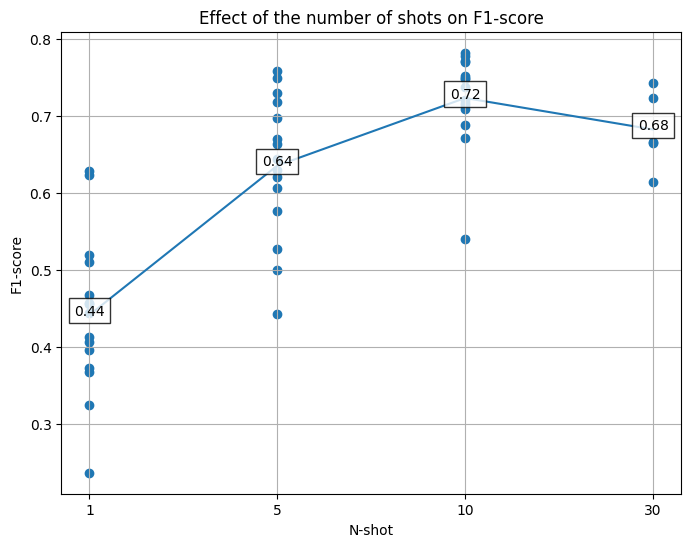

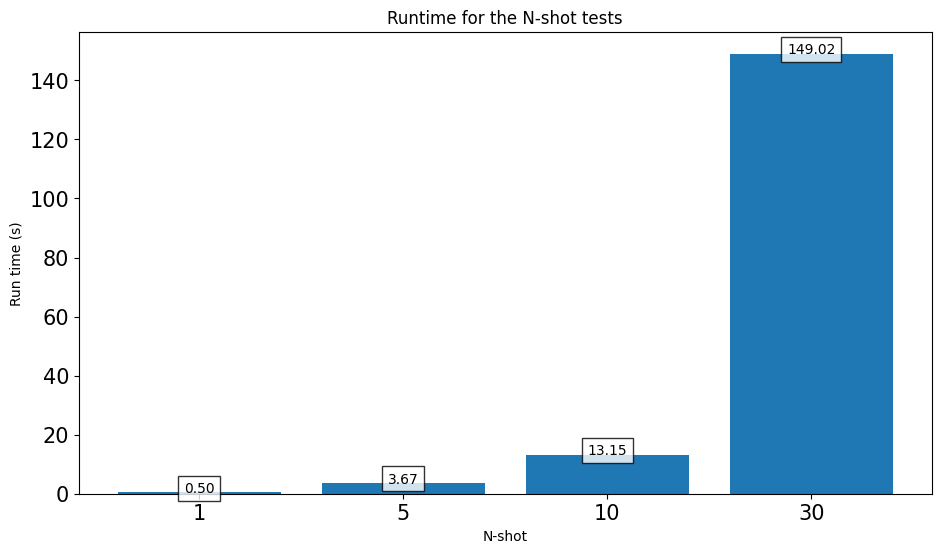

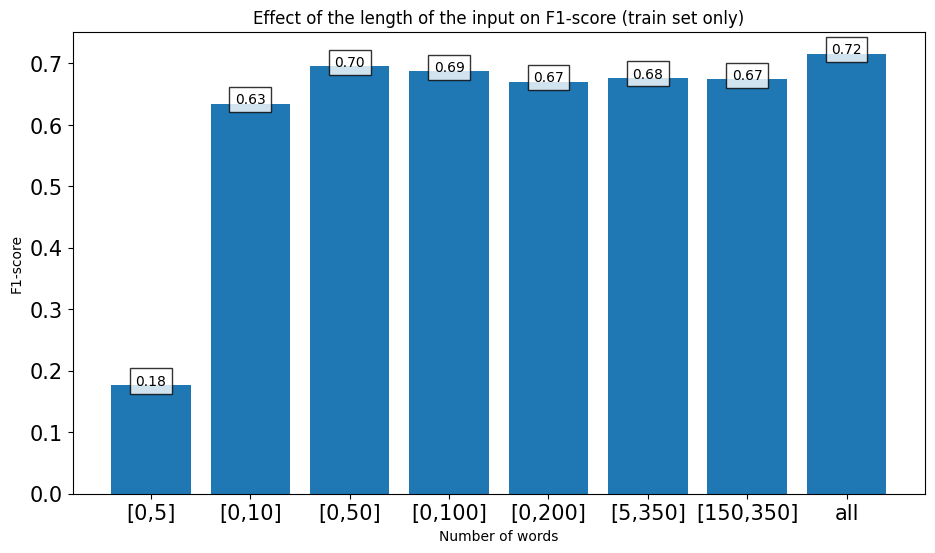

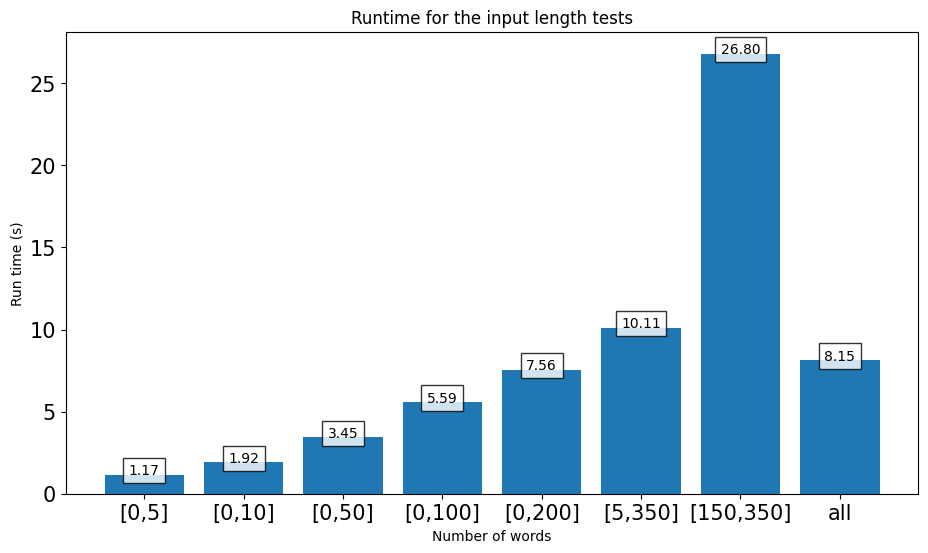

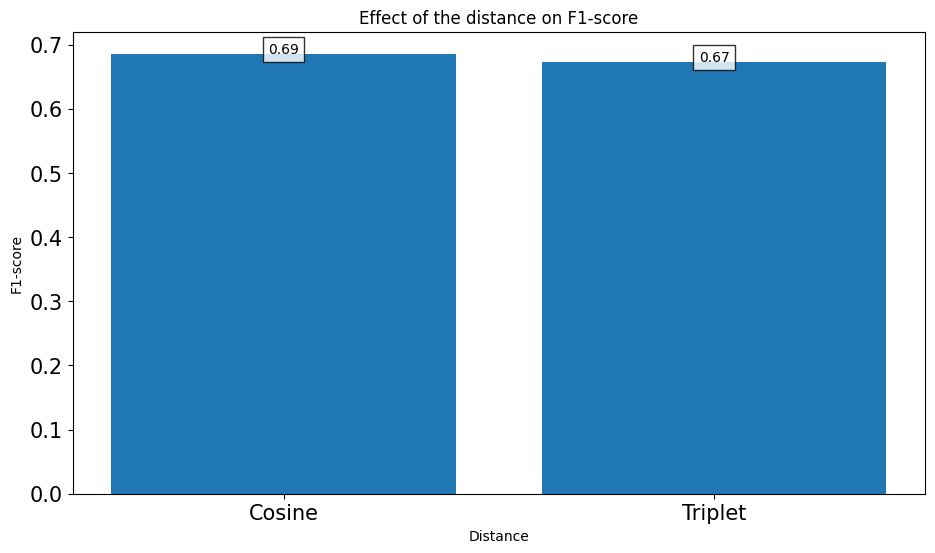

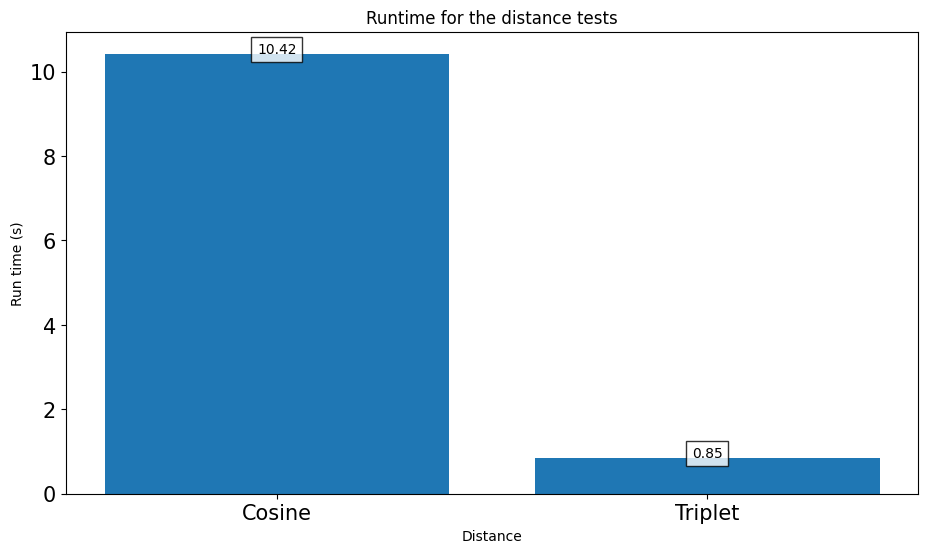

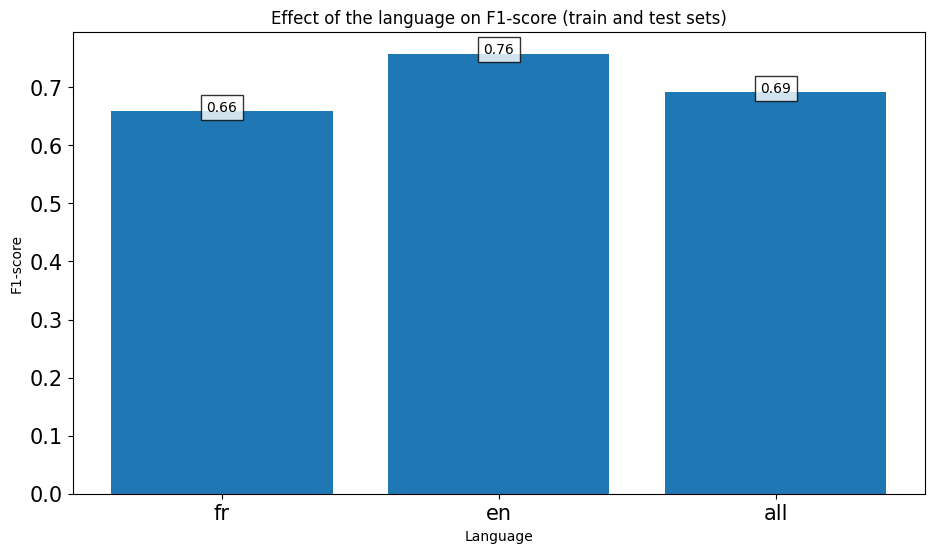

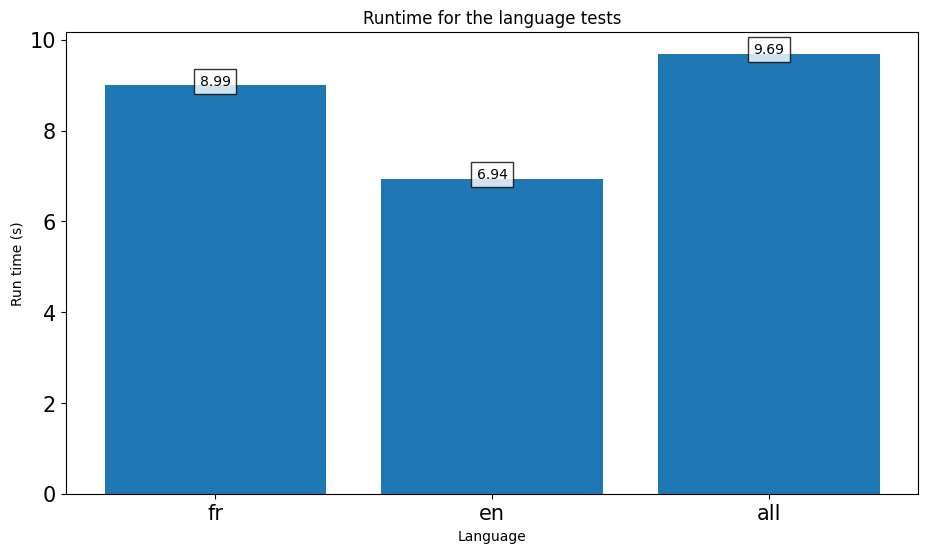

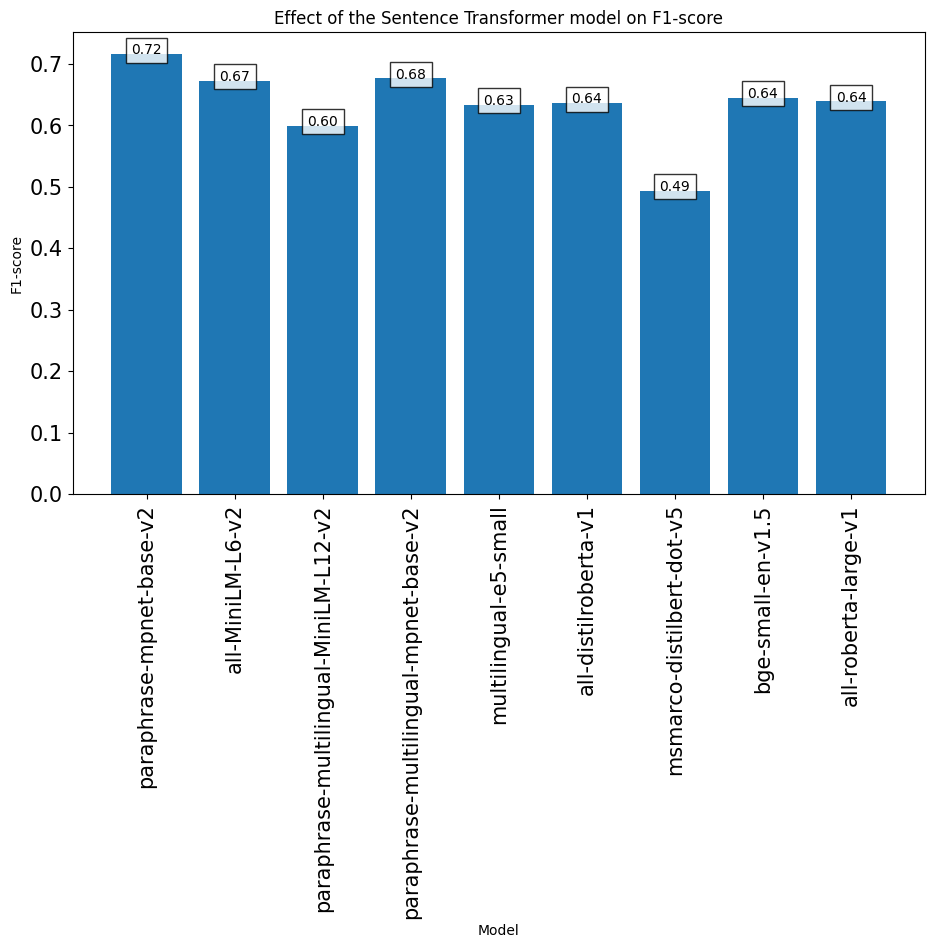

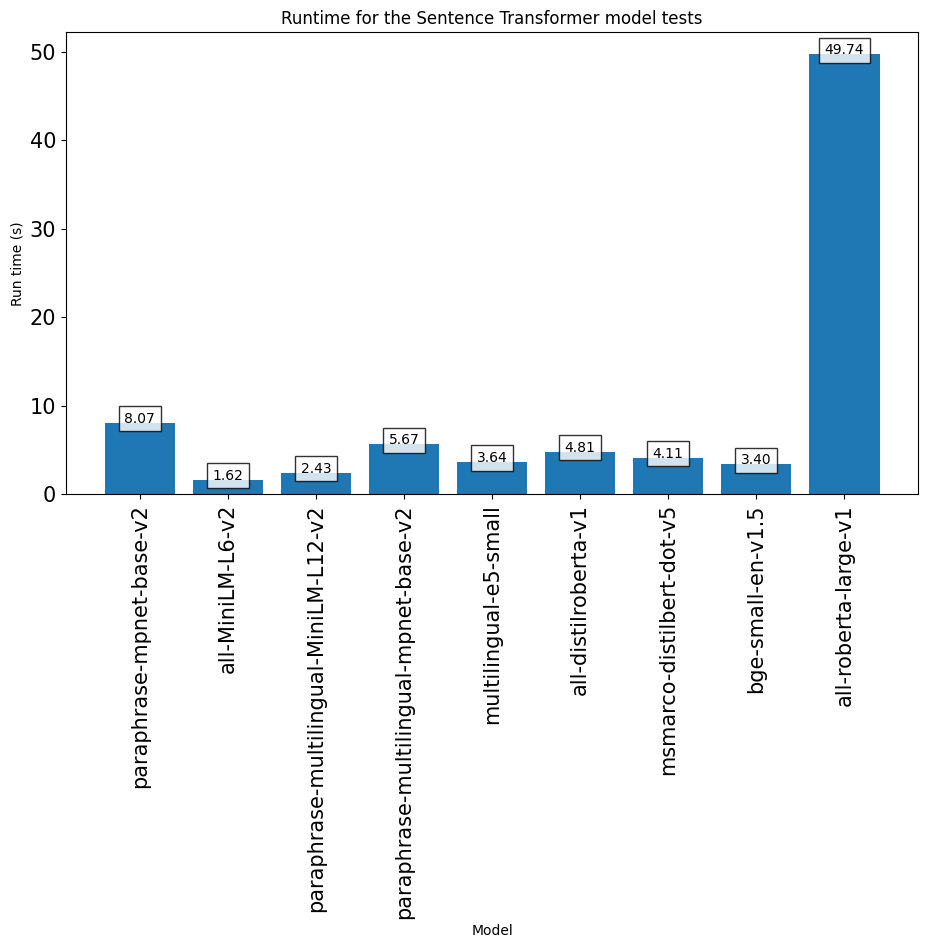

In [31]:
results, run_times = load_latest_results_data(r'../results/setfit/n_shot')
create_scatter_line_plot(results, 'Effect of the number of shots on F1-score', 'N-shot', 'F1-score')
create_bar_plot(run_times, 'Runtime for the N-shot tests', 'N-shot', 'Run time (s)')

results, run_times = load_latest_results_data(r'../results/setfit/input_length')
create_bar_plot(results, 'Effect of the length of the input on F1-score (train set only)', 'Number of words', 'F1-score')
create_bar_plot(run_times, 'Runtime for the input length tests', 'Number of words', 'Run time (s)')

results, run_times = load_latest_results_data(r'../results/setfit/distance')
create_bar_plot(results, 'Effect of the distance on F1-score', 'Distance', 'F1-score')
create_bar_plot(run_times, 'Runtime for the distance tests', 'Distance', 'Run time (s)')

results, run_times = load_latest_results_data(r'../results/setfit/language')
create_bar_plot(results, 'Effect of the language on F1-score (train and test sets)', 'Language', 'F1-score')
create_bar_plot(run_times, 'Runtime for the language tests', 'Language', 'Run time (s)')

results, run_times = load_latest_results_data(r'../results/setfit/model')
create_bar_plot(results, 'Effect of the Sentence Transformer model on F1-score', 'Model', 'F1-score', vertical_xticks=True)
create_bar_plot(run_times, 'Runtime for the Sentence Transformer model tests', 'Model', 'Run time (s)', vertical_xticks=True)

## Hyperparameter Optimization (with optuna)

In [24]:
from typing import Dict, Any, Union
from optuna import Trial

def model_init(params: Dict[str, Any]) -> SetFitModel:
    params = params or {}
    max_iter = params.get("max_iter", 100)
    solver = params.get("solver", "liblinear")
    params = {
        "head_params": {
            "max_iter": max_iter,
            "solver": solver,
        }
    }
    return SetFitModel.from_pretrained("sentence-transformers/paraphrase-multilingual-mpnet-base-v2", **params)

def hp_space(trial: Trial) -> Dict[str, Union[float, int, str]]:
    return {
        "body_learning_rate": trial.suggest_float("body_learning_rate", 1e-6, 1e-3, log=True),
        "num_epochs": trial.suggest_int("num_epochs", 1, 2),
        "batch_size": trial.suggest_categorical("batch_size", [8, 16, 32]),
        "seed": trial.suggest_int("seed", 1, 40),
        "max_iter": trial.suggest_int("max_iter", 50, 300),
        "solver": trial.suggest_categorical("solver", ["newton-cg", "lbfgs", "liblinear"]),
    }
    
new_train_set = Dataset.from_pandas(train_set, split="train")
new_train_set = sample_dataset(new_train_set, label_column="label", num_samples=8)
new_test_set = Dataset.from_pandas(test_set, split="test")

trainer = Trainer(
    train_dataset=new_train_set,
    eval_dataset=new_train_set,
    model_init=model_init,
    metric='f1',
)

best_run = trainer.hyperparameter_search(direction="maximize", hp_space=hp_space, n_trials=10)

g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

[I 2024-03-12 10:59:00,286] A new study created in memory with name: no-name-81a498ba-1c43-4517-9a46-c9b0263b94c5
Trial: {'body_learning_rate': 7.519320847921251e-06, 'num_epochs': 1, 'batch_size': 32, 'seed': 37, 'max_iter': 270, 'solver': 'newton-cg'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num unique pairs = 144
  Batch size = 32
  Num epochs = 1
  Total optimization steps = 5


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

{'embedding_loss': 0.185, 'learning_rate': 7.519320847921251e-06, 'epoch': 0.2}
{'train_runtime': 8.74, 'train_samples_per_second': 18.307, 'train_steps_per_second': 0.572, 'epoch': 1.0}


***** Running evaluation *****
[I 2024-03-12 10:59:13,075] Trial 0 finished with value: 1.0 and parameters: {'body_learning_rate': 7.519320847921251e-06, 'num_epochs': 1, 'batch_size': 32, 'seed': 37, 'max_iter': 270, 'solver': 'newton-cg'}. Best is trial 0 with value: 1.0.
Trial: {'body_learning_rate': 0.0006172627601812052, 'num_epochs': 1, 'batch_size': 16, 'seed': 2, 'max_iter': 230, 'solver': 'lbfgs'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num unique pairs = 144
  Batch size = 16
  Num epochs = 1
  Total optimization steps = 9


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'embedding_loss': 0.1758, 'learning_rate': 0.0006172627601812052, 'epoch': 0.11}
{'train_runtime': 7.603, 'train_samples_per_second': 18.94, 'train_steps_per_second': 1.184, 'epoch': 1.0}


***** Running evaluation *****
[I 2024-03-12 10:59:25,044] Trial 1 finished with value: 1.0 and parameters: {'body_learning_rate': 0.0006172627601812052, 'num_epochs': 1, 'batch_size': 16, 'seed': 2, 'max_iter': 230, 'solver': 'lbfgs'}. Best is trial 0 with value: 1.0.
Trial: {'body_learning_rate': 0.000984081092260427, 'num_epochs': 1, 'batch_size': 8, 'seed': 2, 'max_iter': 99, 'solver': 'liblinear'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num unique pairs = 144
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 18


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.1523, 'learning_rate': 0.0004920405461302135, 'epoch': 0.06}


[W 2024-03-12 10:59:35,520] Trial 2 failed with parameters: {'body_learning_rate': 0.000984081092260427, 'num_epochs': 1, 'batch_size': 8, 'seed': 2, 'max_iter': 99, 'solver': 'liblinear'} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\integrations.py", line 27, in _objective
    trainer.train(trial=trial)
  File "g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\trainer.py", line 410, in train
    self.train_embeddings(*full_parameters, args=args)
  File "g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\train

KeyboardInterrupt: 

In [ ]:
print(best_run)

BestRun(run_id='5', objective=0.7518796992481203, hyperparameters={'body_learning_rate': 4.728450837202361e-05, 'num_epochs': 2, 'batch_size': 32, 'seed': 3, 'max_iter': 105, 'solver': 'lbfgs'}, backend=<optuna.study.study.Study object at 0x0000022B91EB03D0>)


In [ ]:
trainer.apply_hyperparameters(best_run.hyperparameters, final_model=True)
trainer.train()

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num unique pairs = 220
  Batch size = 32
  Num epochs = 2
  Total optimization steps = 14


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

{'embedding_loss': 0.2414, 'learning_rate': 2.3642254186011806e-05, 'epoch': 0.14}
{'train_runtime': 38.209, 'train_samples_per_second': 11.725, 'train_steps_per_second': 0.366, 'epoch': 2.0}


In [ ]:
trainer.evaluate()

***** Running evaluation *****


{'f1': 0.7518796992481203}